Try setting OPM_NUM_THREADS=1.

In [2]:
import glob
import itertools
import logging
from operator import attrgetter
import os
import pprint
import time

import matplotlib.pyplot as plt
%matplotlib inline
import scipy.misc

import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import sklearn.utils

from mrfitty.base import AdaptiveEnergyRangeBuilder, ReferenceSpectrum, Spectrum, InterpolatedReferenceSpectraSet
from mrfitty.best_subset_selection import BestSubsetSelectionFitTask
from mrfitty.combination_fit import AllCombinationFitTask
from mrfitty.loss import NormalizedSumOfSquares, PredictionError

logging.basicConfig(level=logging.WARN)

In [3]:
class InterpolatedSpectrumSet:
    def __init__(self, spectrum_set):
        self.interpolated_set_df = InterpolatedSpectrumSet.get_interpolated_spectrum_set_df(
            spectrum_set=spectrum_set)

    @staticmethod
    def get_interpolated_spectrum_set_df(energy_range, spectrum_set):
        """ Return a pandas.DataFrame of spectrum values interpolated at the specified energies.
        
        
        """
        # the interpolated spectra will be len(energy_range) x len(reference_set)
        interpolated_spectra = np.zeros((len(energy_range), len(spectrum_set)))
        column_names = []
        for i, spectrum in enumerate(sorted(list(spectrum_set), key=lambda s: s.file_name)):
            column_names.append(spectrum.file_name)
            interpolated_spectra[:, i] = spectrum.interpolant(energy_range)
            # set values that would be extrapolated to NaN
            ndx = InterpolatedSpectrumSet.get_extrapolated_value_index(
                interpolated_energy=energy_range,
                measured_energy=spectrum.data_df.energy.values)
            # print(ndx)
            interpolated_spectra[ndx, i] = np.nan

        interpolated_spectra_df = pd.DataFrame(
            data=interpolated_spectra,
            index=energy_range,
            columns=column_names)

        return interpolated_spectra_df

    @staticmethod
    def get_extrapolated_value_index(interpolated_energy, measured_energy):
        """Return a boolean array with True indicating interpolated energies outside the measured energy range.
        
        :param interpolated_energy (np.array)
        :param measured_energy (np.array)
        :returns (numpy boolean array) 
        """
        extrapolated_value_boolean_index = np.logical_or(
            interpolated_energy < measured_energy[0],
            interpolated_energy > measured_energy[-1] )
        return np.where(extrapolated_value_boolean_index)


In [4]:
arsenic_archived_cores_data_dir_path = '/home/jlynch/host/project/th_sln/archived_tills_for_trees_Jan_30_2017/'
os.path.exists(arsenic_archived_cores_data_dir_path)

False

Read all arsenic spectra in the core directories.

In [4]:
arsenic_archived_reference_glob = os.path.join(arsenic_archived_cores_data_dir_path, 'As_references/*.e')
print('references glob: {}'.format(arsenic_archived_reference_glob))
arsenic_archived_cores_spectrum_glob = os.path.join(arsenic_archived_cores_data_dir_path, '*/*_As_XANES/*.e')
print('cores glob: {}'.format(arsenic_archived_cores_spectrum_glob))

references glob: /home/jlynch/host/project/th_sln/archived_tills_for_trees_Jan_30_2017/As_references/*.e
cores glob: /home/jlynch/host/project/th_sln/archived_tills_for_trees_Jan_30_2017/*/*_As_XANES/*.e


In [5]:
arsenic_archived_reference_list, _ = list(ReferenceSpectrum.read_all([arsenic_archived_reference_glob]))
print('refrence count: {}'.format(len(arsenic_archived_reference_list)))
arsenic_archived_cores_spectrum_list, _ = list(ReferenceSpectrum.read_all([arsenic_archived_cores_spectrum_glob]))
print('core spectrum count: {}'.format(len(arsenic_archived_cores_spectrum_list)))

refrence count: 4
core spectrum count: 70


What are the maximum and minimum reference energies?

In [6]:
reference_min_energy = np.max([r.data_df.energy.values[0] for r in arsenic_archived_reference_list])
reference_max_energy = np.min([r.data_df.energy.values[-1] for r in arsenic_archived_reference_list])
print('reference minimum energy: {:5.2f}'.format(reference_min_energy))
print('reference maximum energy: {:5.2f}'.format(reference_max_energy))

reference minimum energy: 11830.00
reference maximum energy: 12097.14


What are the maximum and minimum core spectrum energies?

In [7]:
min_energy = np.max([r.data_df.energy.values[0] for r in arsenic_archived_cores_spectrum_list])
max_energy = np.min([r.data_df.energy.values[-1] for r in arsenic_archived_cores_spectrum_list])
print('minimum energy: {:5.2f}'.format(min_energy))
print('maximum energy: {:5.2f}'.format(max_energy))

minimum energy: 11791.80
maximum energy: 12074.23


In [8]:
interpolate_energy_range = np.linspace(start=11860.0, stop=11920.0, num=200)
print('interpolate_energy_range.shape: {}'.format(interpolate_energy_range.shape))
print('interpolate_energy_range:\n{}'.format(pprint.pformat(interpolate_energy_range.tolist()[:10])))

interpolate_energy_range.shape: (200,)
interpolate_energy_range:
[11860.0,
 11860.301507537688,
 11860.603015075378,
 11860.904522613066,
 11861.206030150754,
 11861.507537688442,
 11861.809045226131,
 11862.11055276382,
 11862.412060301507,
 11862.713567839195]


,Arsenate_sorbed_to_goethite_standard.e,Arsenopyrite_standard.e,Fh2l_sorbed_arsenite_pH7_10um_als_standard.e,OTT3_55_spot0_aquitard.e,OTT3_55_spot3 _aquitard.e,OTT3_55_spot4_aquitard.e,OTT3_55_spot_0a2_aquitard.e,OTT3_55_spot_1_aquitard.e,OTT3_55_spot_1a2_aquitard.e,OTT3_55_spot_2_aquitard.e,...,UMRB2_165_spot_1_aquifer.e,UMRB2_165_spot_1a2_aquifer.e,UMRB2_165_spot_2a2_aquifer.e,UMRB2_165_spot_3_aquifer.e,UMRB2_165_spot_4_aquifer.e,UMRB2_167_spot_0_contact.e,UMRB2_167_spot_1_contact.e,UMRB2_167_spot_2_contact.e,UMRB2_167_spot_3_contact.e,UMRB2_167_spot_4_contact.e
11860.000000,0.013935,0.041302,0.018826,0.068209,0.053664,0.156887,0.066389,0.059904,0.068583,0.042651,...,0.043375,0.078980,0.044449,0.017209,0.055146,0.052544,0.076167,0.051706,0.046937,0.035318
11860.301508,0.013858,0.040921,0.021781,0.066683,0.057190,0.094178,0.078998,0.036546,0.080531,0.059590,...,0.035412,0.073873,0.037420,0.030195,0.086437,0.051962,0.082946,0.053842,0.045212,0.047977
11860.603015,0.018936,0.042627,0.025445,0.064741,0.051915,0.045199,0.085418,0.027556,0.086100,0.045349,...,0.053885,0.070498,0.072416,0.046433,0.121166,0.044876,0.068552,0.054650,0.053420,0.044576
11860.904523,0.017715,0.065637,0.028571,0.064912,0.052837,0.072358,0.088314,0.035168,0.088979,0.024259,...,0.069342,0.075524,0.080985,0.040903,0.095486,0.046579,0.050266,0.056096,0.068576,0.043694
11861.206030,0.015531,0.105818,0.034054,0.073341,0.075159,0.117088,0.092364,0.056064,0.093477,0.017632,...,0.063193,0.088581,0.045167,0.040238,0.050889,0.059331,0.057574,0.061631,0.071838,0.047850


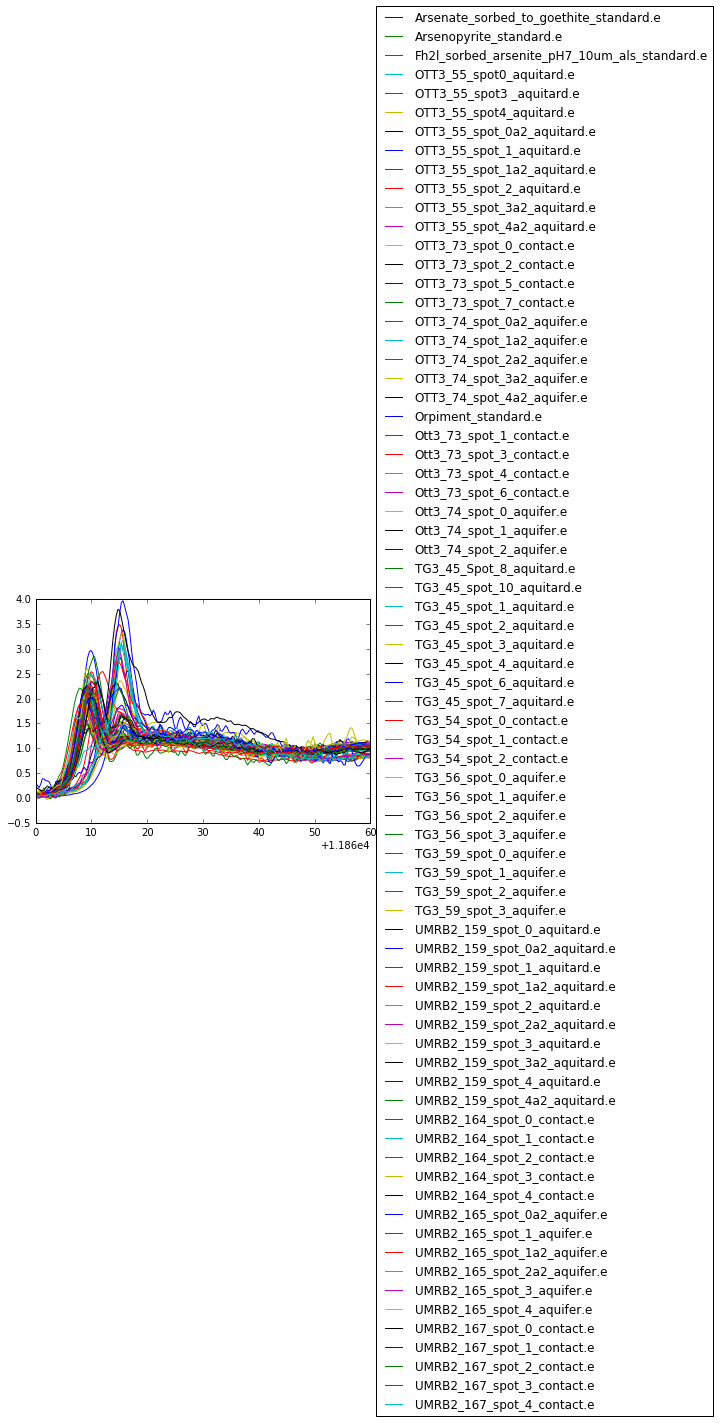

In [9]:
# interpolate references and spectra in one data frame because concatentating data frames with a 
# floating point index is not working for me
interpolated_arsenic_archived_ref_and_cores_df = InterpolatedSpectrumSet.get_interpolated_spectrum_set_df(
    energy_range=interpolate_energy_range,
    spectrum_set=set(itertools.chain(arsenic_archived_reference_list, arsenic_archived_cores_spectrum_list)))
interpolated_arsenic_archived_ref_and_cores_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
interpolated_arsenic_archived_ref_and_cores_df.head()

In [10]:
def permute_row_elements(df):
    for i in range(df.shape[0]):
        df.values[i, :] = sklearn.utils.shuffle(df.values[i, :])
    return df
# demonstrate permuting row elements
x_df = pd.DataFrame(data=np.array(range(9)).reshape((3,3)))
print('before permuting row elements:')
print(x_df.head())
permute_row_elements(x_df)
print('after permuting row elements:')
print(x_df)

before permuting row elements:
   0  1  2
0  0  1  2
1  3  4  5
2  6  7  8
after permuting row elements:
   0  1  2
0  2  0  1
1  4  5  3
2  6  7  8


In [11]:
def cluster_with_sig_cut(variable_by_sample_df, title, pdist_metric, linkage_method):
    #pdist_metric = 'correlation'
    distance_for_sample_pairs = pdist(X=np.transpose(variable_by_sample_df.values), metric=pdist_metric)
    print('{}: {} sample pairs'.format(title, len(distance_for_sample_pairs)))
    plt.figure()
    plt.title(title)
    plt.hist(distance_for_sample_pairs)
    plt.xlabel('{} distance'.format(pdist_metric))
    plt.ylabel('{} pairs'.format(variable_by_sample_df.shape))
    plt.show()

    resample_count = 1000
    expected_distance_list = []
    for i in range(resample_count):
        # permute the elements of each row of variable_by_sample_df
        p_variable_by_sample_df = permute_row_elements(variable_by_sample_df.copy())
        p_distance_for_sample_pairs = pdist(X=np.transpose(p_variable_by_sample_df.values), metric=pdist_metric)
        p_linkage_distance_variable_by_sample = hc.linkage(y=p_distance_for_sample_pairs, method=linkage_method)
        p_dendrogram = hc.dendrogram(Z=p_linkage_distance_variable_by_sample, no_plot=True)
        expected_distance_list.extend([d for (_, _, d, _) in p_dendrogram['dcoord']])

    p = 95.0
    alpha = 1.0 - p/100.0
    cutoff_distance = np.percentile(expected_distance_list, q=p)
    print('cutoff distance is {}'.format(cutoff_distance))

    plt.figure()
    plt.hist(expected_distance_list)
    plt.title('dendrogram distance null distribution')
    plt.show()

    linkage_distance_variable_by_sample = hc.linkage(y=distance_for_sample_pairs, method=linkage_method)
    plt.figure(figsize=(3.75, 7.0))
    dendrogram = hc.dendrogram(
        Z=linkage_distance_variable_by_sample,
        orientation='left',
        labels=variable_by_sample_df.columns)
    
    icoords = [i for i in itertools.chain(dendrogram['icoord'])]
    
    plt.vlines(cutoff_distance, ymin=np.min(icoords), ymax=np.max(icoords))
    dendrogram_title = '{}\n{} linkage'.format(title, linkage_method)
    plt.title(dendrogram_title)
    plt.xlabel('{} distance'.format(pdist_metric))
    plt.savefig(title + '.pdf', format='pdf')
    plt.show()
    


reference column list has 4 elements:
('Arsenate_sorbed_to_goethite_standard.e',
 'Arsenopyrite_standard.e',
 'Fh2l_sorbed_arsenite_pH7_10um_als_standard.e',
 'Orpiment_standard.e')
core OTT3 column list has 18 elements:
('OTT3_55_spot0_aquitard.e',
 'OTT3_55_spot3 _aquitard.e',
 'OTT3_55_spot4_aquitard.e',
 'OTT3_55_spot_0a2_aquitard.e',
 'OTT3_55_spot_1_aquitard.e',
 'OTT3_55_spot_1a2_aquitard.e',
 'OTT3_55_spot_2_aquitard.e',
 'OTT3_55_spot_3a2_aquitard.e',
 'OTT3_55_spot_4a2_aquitard.e',
 'OTT3_73_spot_0_contact.e',
 'OTT3_73_spot_2_contact.e',
 'OTT3_73_spot_5_contact.e',
 'OTT3_73_spot_7_contact.e',
 'OTT3_74_spot_0a2_aquifer.e',
 'OTT3_74_spot_1a2_aquifer.e',
 'OTT3_74_spot_2a2_aquifer.e',
 'OTT3_74_spot_3a2_aquifer.e',
 'OTT3_74_spot_4a2_aquifer.e')
core OTT3 (18 spectra): 153 sample pairs


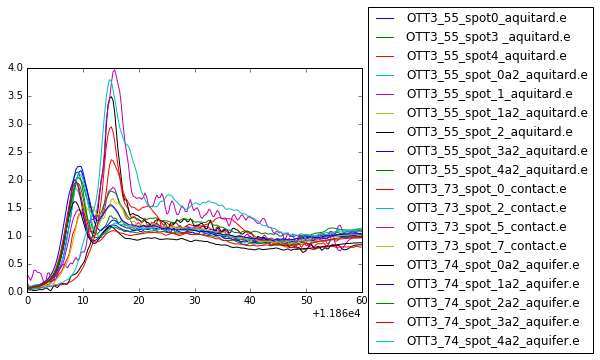

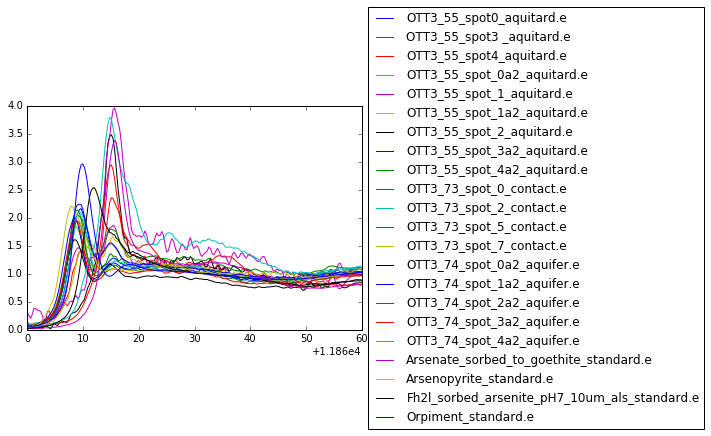

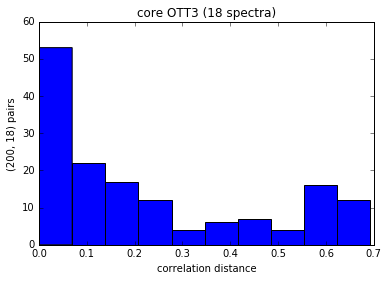

cutoff distance is 0.5241886035026839


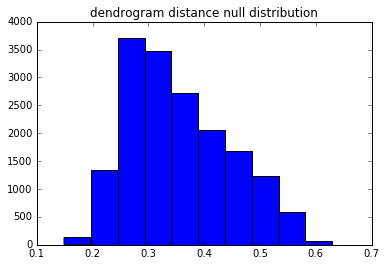

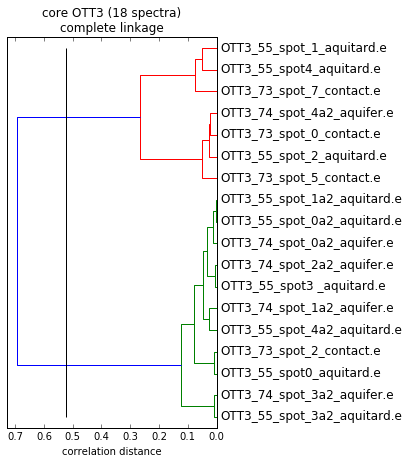

core OTT3 and references (22 spectra): 231 sample pairs


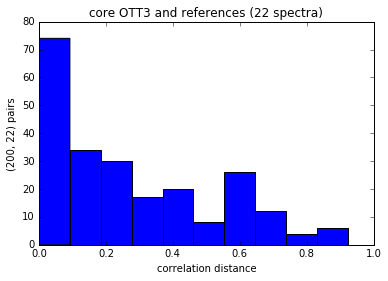

cutoff distance is 0.5579309508429149


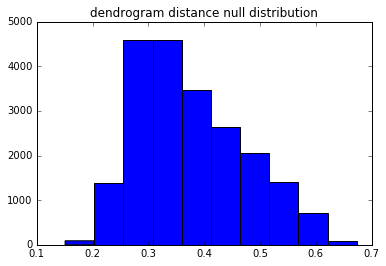

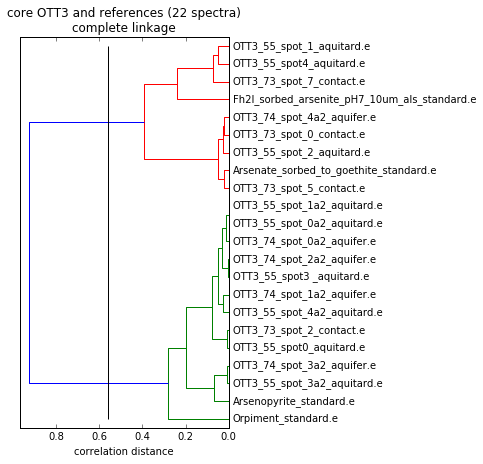

reference column list has 4 elements:
('Arsenate_sorbed_to_goethite_standard.e',
 'Arsenopyrite_standard.e',
 'Fh2l_sorbed_arsenite_pH7_10um_als_standard.e',
 'Orpiment_standard.e')
core TG3 column list has 19 elements:
('TG3_45_Spot_8_aquitard.e',
 'TG3_45_spot_10_aquitard.e',
 'TG3_45_spot_1_aquitard.e',
 'TG3_45_spot_2_aquitard.e',
 'TG3_45_spot_3_aquitard.e',
 'TG3_45_spot_4_aquitard.e',
 'TG3_45_spot_6_aquitard.e',
 'TG3_45_spot_7_aquitard.e',
 'TG3_54_spot_0_contact.e',
 'TG3_54_spot_1_contact.e',
 'TG3_54_spot_2_contact.e',
 'TG3_56_spot_0_aquifer.e',
 'TG3_56_spot_1_aquifer.e',
 'TG3_56_spot_2_aquifer.e',
 'TG3_56_spot_3_aquifer.e',
 'TG3_59_spot_0_aquifer.e',
 'TG3_59_spot_1_aquifer.e',
 'TG3_59_spot_2_aquifer.e',
 'TG3_59_spot_3_aquifer.e')
core TG3 (19 spectra): 171 sample pairs


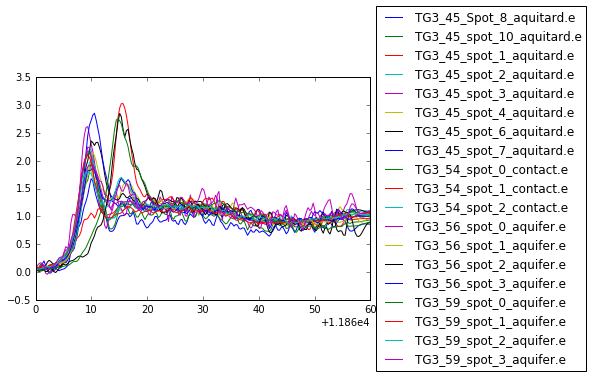

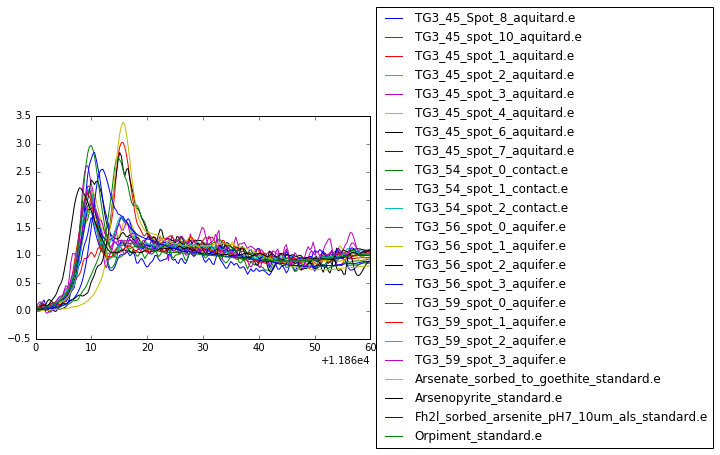

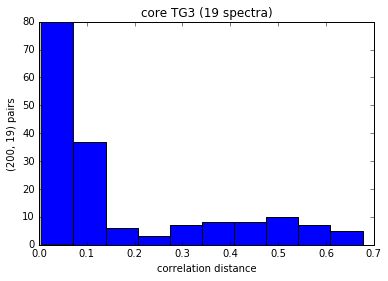

cutoff distance is 0.3671959368303407


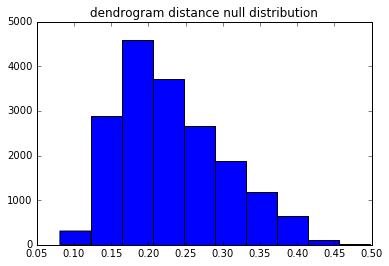

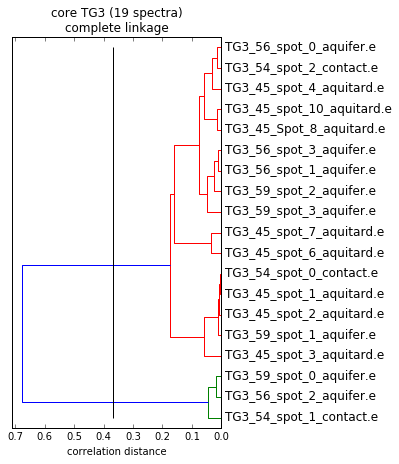

core TG3 and references (23 spectra): 253 sample pairs


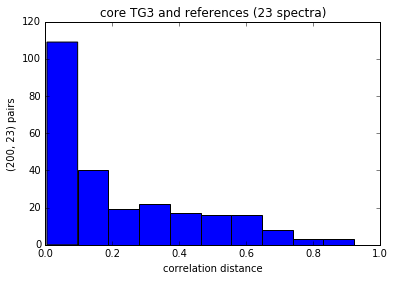

cutoff distance is 0.44947372377636785


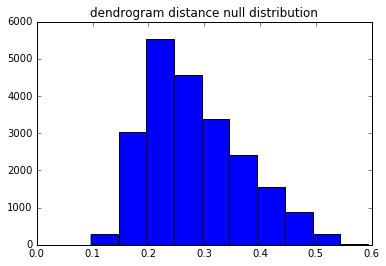

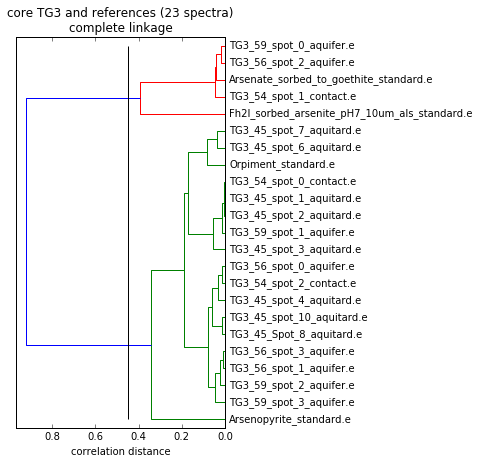

reference column list has 4 elements:
('Arsenate_sorbed_to_goethite_standard.e',
 'Arsenopyrite_standard.e',
 'Fh2l_sorbed_arsenite_pH7_10um_als_standard.e',
 'Orpiment_standard.e')
core UMRB2 column list has 26 elements:
('UMRB2_159_spot_0_aquitard.e',
 'UMRB2_159_spot_0a2_aquitard.e',
 'UMRB2_159_spot_1_aquitard.e',
 'UMRB2_159_spot_1a2_aquitard.e',
 'UMRB2_159_spot_2_aquitard.e',
 'UMRB2_159_spot_2a2_aquitard.e',
 'UMRB2_159_spot_3_aquitard.e',
 'UMRB2_159_spot_3a2_aquitard.e',
 'UMRB2_159_spot_4_aquitard.e',
 'UMRB2_159_spot_4a2_aquitard.e',
 'UMRB2_164_spot_0_contact.e',
 'UMRB2_164_spot_1_contact.e',
 'UMRB2_164_spot_2_contact.e',
 'UMRB2_164_spot_3_contact.e',
 'UMRB2_164_spot_4_contact.e',
 'UMRB2_165_spot_0a2_aquifer.e',
 'UMRB2_165_spot_1_aquifer.e',
 'UMRB2_165_spot_1a2_aquifer.e',
 'UMRB2_165_spot_2a2_aquifer.e',
 'UMRB2_165_spot_3_aquifer.e',
 'UMRB2_165_spot_4_aquifer.e',
 'UMRB2_167_spot_0_contact.e',
 'UMRB2_167_spot_1_contact.e',
 'UMRB2_167_spot_2_contact.e',
 'UMRB2_

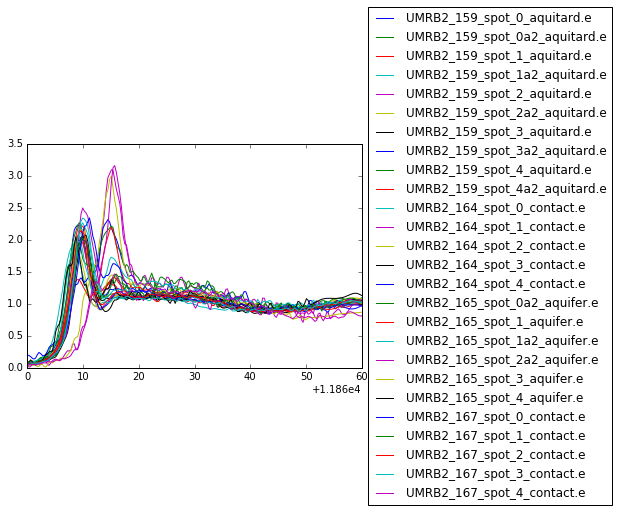

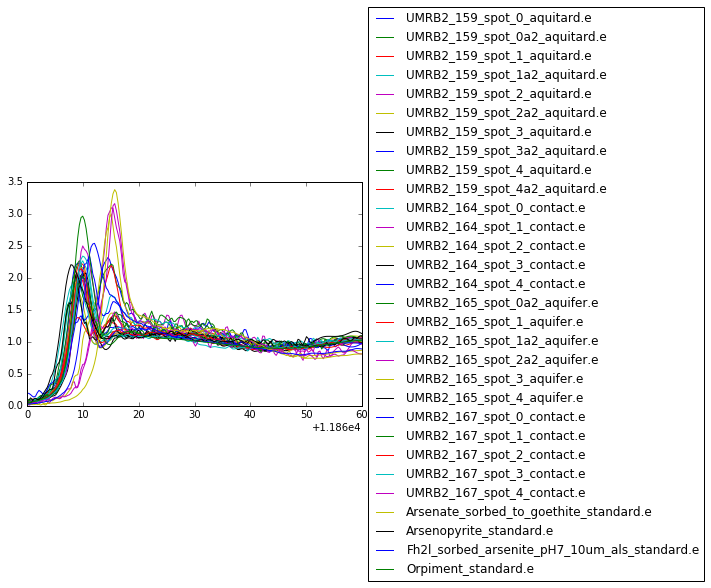

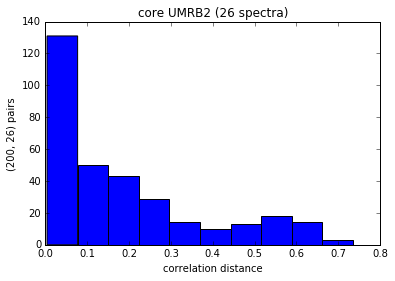

cutoff distance is 0.3786226004432381


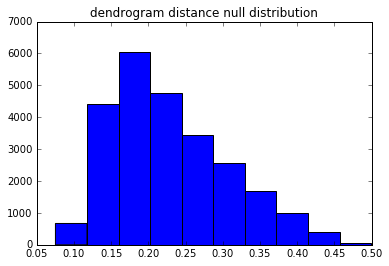

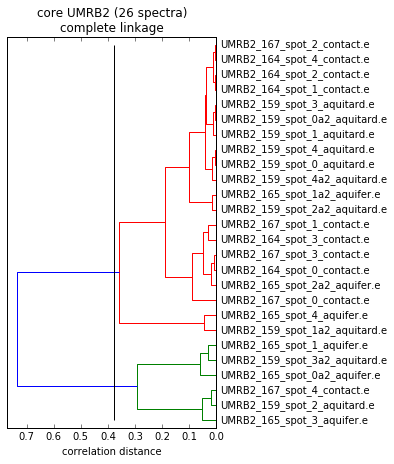

core UMRB2 and references (30 spectra): 435 sample pairs


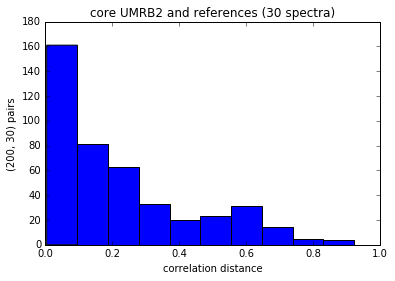

cutoff distance is 0.44284839381809554


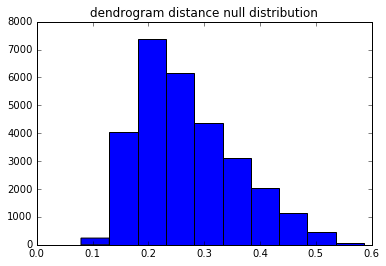

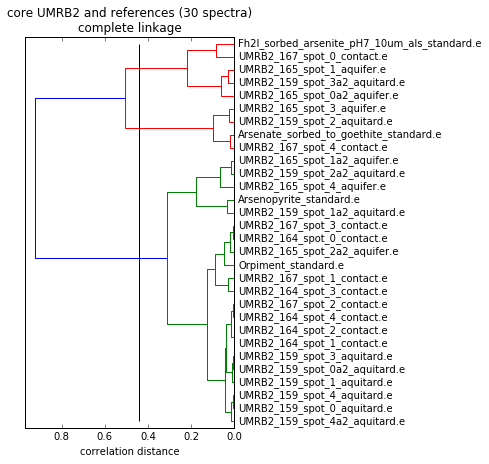

In [12]:
for core in ['OTT3', 'TG3', 'UMRB2']:
    # combine core and references
    ref_column_list = tuple([c for c in interpolated_arsenic_archived_ref_and_cores_df.columns if 'standard' in c])
    print('reference column list has {} elements:\n{}'.format(len(ref_column_list), pprint.pformat(ref_column_list)))
    core_column_list = tuple([c for c in interpolated_arsenic_archived_ref_and_cores_df.columns if core in c])
    print('core {} column list has {} elements:\n{}'.format(core, len(core_column_list), pprint.pformat(core_column_list)))
    core_interpolated_arsenic_archived_df = interpolated_arsenic_archived_ref_and_cores_df.loc[:, core_column_list]
    core_interpolated_arsenic_archived_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    core_interpolated_arsenic_archived_df.head()

    core_and_ref_column_list = tuple(itertools.chain(core_column_list, ref_column_list))
    core_and_ref_interpolated_arsenic_archived_df = interpolated_arsenic_archived_ref_and_cores_df.loc[:, core_and_ref_column_list]
    core_and_ref_interpolated_arsenic_archived_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    core_and_ref_interpolated_arsenic_archived_df.head()

    cluster_with_sig_cut(
        core_interpolated_arsenic_archived_df,
        title='core {} ({} spectra)'.format(core, core_interpolated_arsenic_archived_df.shape[1]),
        pdist_metric='correlation',
        linkage_method='complete')

    cluster_with_sig_cut(
        core_and_ref_interpolated_arsenic_archived_df,
        title='core {} and references ({} spectra)'.format(core, core_and_ref_interpolated_arsenic_archived_df.shape[1]),
        pdist_metric='correlation',
        linkage_method='complete')


reference column list has 4 elements:
('Arsenate_sorbed_to_goethite_standard.e',
 'Arsenopyrite_standard.e',
 'Fh2l_sorbed_arsenite_pH7_10um_als_standard.e',
 'Orpiment_standard.e')
all cores column list has UMRB2 elements:
70
As all cores(70 spectra): 2415 sample pairs


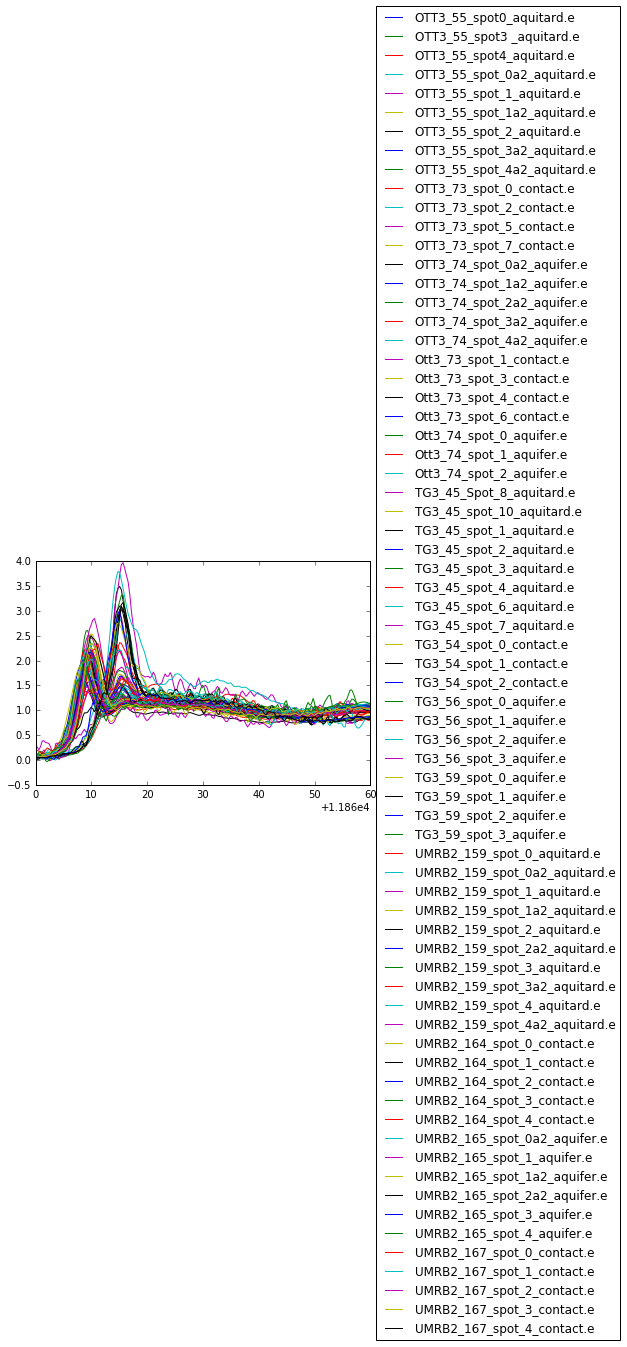

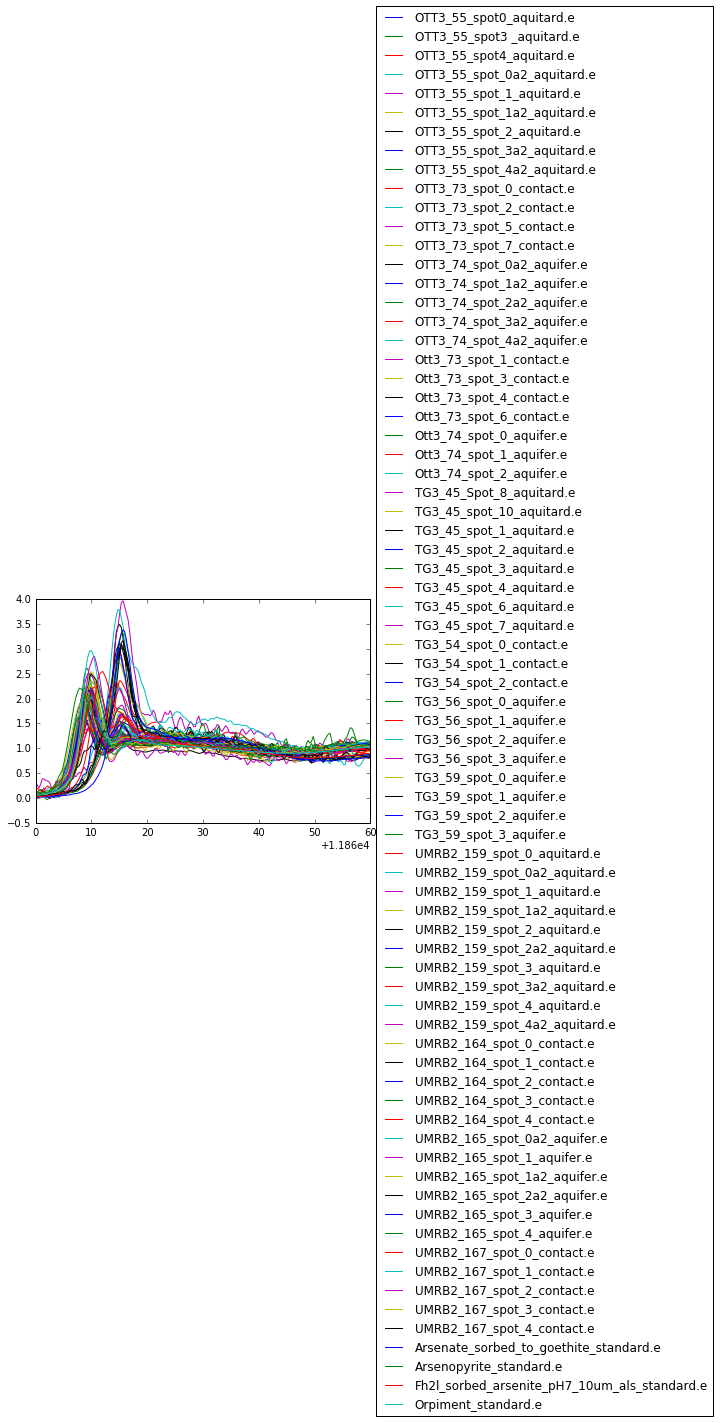

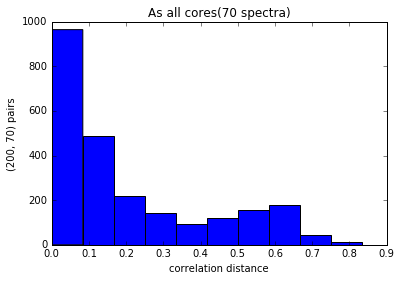

cutoff distance is 0.4395266279018474


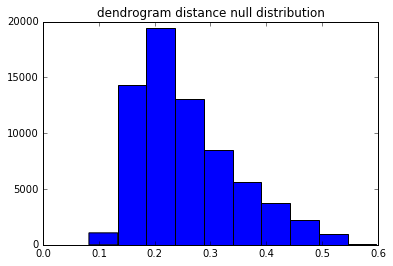

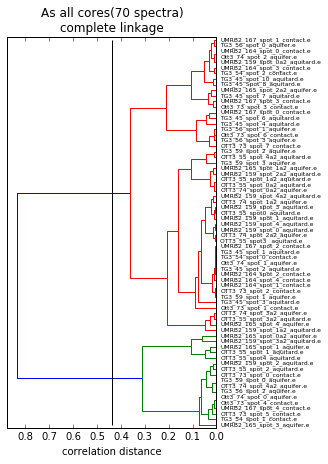

As all cores and references (74 spectra): 2701 sample pairs


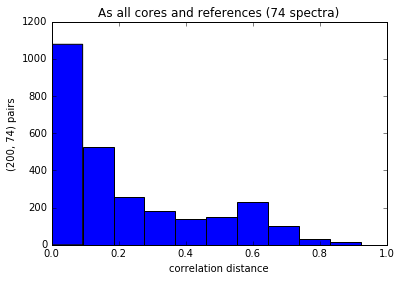

cutoff distance is 0.45614580407528443


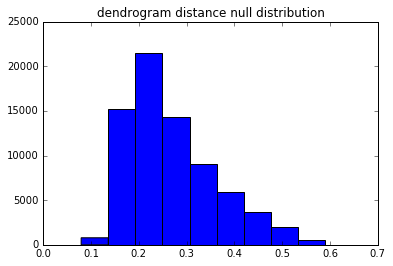

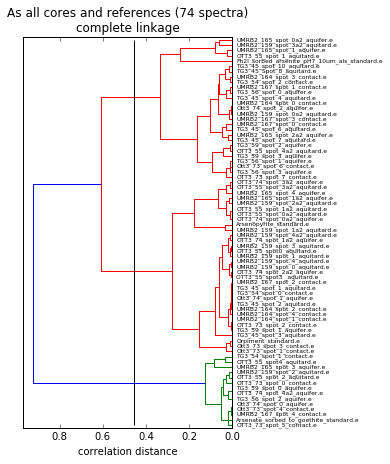

In [13]:
# all cores
ref_column_list = tuple([c for c in interpolated_arsenic_archived_ref_and_cores_df.columns if 'standard' in c])
print('reference column list has {} elements:\n{}'.format(len(ref_column_list), pprint.pformat(ref_column_list)))

core_column_list = tuple([c for c in interpolated_arsenic_archived_ref_and_cores_df.columns if 'standard' not in c])
print('all cores column list has {} elements:\n{}'.format(core, len(core_column_list), pprint.pformat(core_column_list)))
core_interpolated_arsenic_archived_df = interpolated_arsenic_archived_ref_and_cores_df.loc[:, core_column_list]
core_interpolated_arsenic_archived_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
core_interpolated_arsenic_archived_df.head()

core_and_ref_column_list = tuple(itertools.chain(core_column_list, ref_column_list))
core_and_ref_interpolated_arsenic_archived_df = interpolated_arsenic_archived_ref_and_cores_df.loc[:, core_and_ref_column_list]
core_and_ref_interpolated_arsenic_archived_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
core_and_ref_interpolated_arsenic_archived_df.head()

cluster_with_sig_cut(
    core_interpolated_arsenic_archived_df,
    title='As all cores({} spectra)'.format(core_interpolated_arsenic_archived_df.shape[1]),
    pdist_metric='correlation',
    linkage_method='complete')

cluster_with_sig_cut(
    core_and_ref_interpolated_arsenic_archived_df,
    title='As all cores and references ({} spectra)'.format(core_and_ref_interpolated_arsenic_archived_df.shape[1]),
    pdist_metric='correlation',
    linkage_method='complete')
